## Лабораторная работа 5. Часть 2.

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.special import expit

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style("dark")
sns.set(font_scale=1.6)

## Задача 1

Реализуйте логистическую регрессию с $\ell_2$ регуляризацией для поиска оценки параметров с помощью стохастического mini-batch градиентного спуска (SGD).

In [3]:
class LogisticRegression():
    '''
    Модель логистической регрессии. Имеет следующие гиперпараметры:

    :param alpha: параметр регуляризации. 
                  Если равно 0, то регуляризация не происходит.
    :param lr: константа, на которую домножаем градиент при обучении
    :param max_iter: ограничение на кол-во итераций
    :param fit_intercept: указывает, следует ли добавить константу в признаки
    '''

    def __init__(self, alpha=0, lr=0.5, max_iter=1e5,
                 fit_intercept=True):
        '''Создает модель и инициализирует параметры.'''

        self.alpha = alpha
        self.lr = lr
        self.max_iter = max_iter
        self.fit_intercept = fit_intercept
        self.coefs = None

    @staticmethod
    def _sigmoid(x):
        # используйте scipy.special.expit
        return expit(x)

    def _add_intercept(self, X):
        '''
        Добавляем свободный коэффициент к нашей модели. 
        Это происходит путем добавления вектора из 1 к исходной матрице.

        :param X: исходная матрица признаков
        :return: матрица X с добавленным свободным коэффициентов
        '''

        X_copy = np.full((X.shape[0], X.shape[1] + 1), fill_value=1)
        X_copy[:, :-1] = X

        return X_copy

    def calc_grad(self, X, y):
        return 2 * self.alpha * self.coefs - X.T @ (y - self._sigmoid(X @ self.coefs))

    def fit(self, X, Y):
        '''
        Обучает модель логистической регресии с помощью SGD,
        пока не выполнится self.max_iter итераций.

        :param X: матрица признаков
        :param Y: истинные метки
        '''

        assert X.shape[0] == Y.shape[0]

        if self.fit_intercept:  # добавляем свободный коэфициент
            X_copy = self._add_intercept(X)
        else:
            X_copy = X.copy()

        self.coefs = np.random.random(size=(X_copy.shape[1], 1))

        for i in range(self.max_iter):
           n = X_copy.shape[0]
           bt = np.random.choice(range(n), size=(n // 5))
           grad = self.calc_grad(X_copy[bt], Y[bt])
           self.coefs = self.coefs - self.lr * n / (n // 5) * grad

        if self.fit_intercept:
          self.intercept_ = self.coefs[-1]
          self.coef_ = self.coefs[:-1]
        else:
          self.intercept_ = np.array([[0]])
          self.coef_ = self.coefs
        return self

    def predict(self, X):
        '''
        Применяет обученную модель к данным 
        и возвращает точечное предсказание (оценку класса).

        :param X: матрица признаков
        :return: предсказание с размерностью (n_test, )
        '''
        thetas = self.coef_
        if self.fit_intercept:
            X_copy = self._add_intercept(X)
            thetas = np.vstack((self.coef_, self.intercept_))
        else:
            X_copy = X.copy()

        assert X_copy.shape[1] == thetas.shape[0]

        probability = self._sigmoid(X_copy @ thetas)
        predictions = probability > 0.5
        
        return predictions

    def predict_proba(self, X):
        '''
        Применяет обученную модель к данным
        и возвращает предсказание вероятности классов 0 и 1.

        :param X: матрица признаков
        :return: вероятности предсказания с размерностью (n_test, 2)
        '''
        thetas = self.coef_
        if self.fit_intercept:
            X_copy = self._add_intercept(X)
            thetas = np.vstack((self.coef_, self.intercept_))
        else:
            X_copy = X.copy()

        assert X_copy.shape[1] == thetas.shape[0]

        probability = self._sigmoid(X_copy @ thetas)
        prob_predictions = np.hstack(( 1 - probability, probability))
        return prob_predictions

Рассмотрим игрушечный датасет на $30$ признаков `load_breast_cancer` из библиотеки `sklearn`. Это относительно простой для бинарной классификации датасет по диагностике рака молочной железы.

Ради интереса можно прочитать описание признаков.

In [4]:
dataset = load_breast_cancer()
dataset['DESCR'].split('\n')[11:31]

['    :Attribute Information:',
 '        - radius (mean of distances from center to points on the perimeter)',
 '        - texture (standard deviation of gray-scale values)',
 '        - perimeter',
 '        - area',
 '        - smoothness (local variation in radius lengths)',
 '        - compactness (perimeter^2 / area - 1.0)',
 '        - concavity (severity of concave portions of the contour)',
 '        - concave points (number of concave portions of the contour)',
 '        - symmetry',
 '        - fractal dimension ("coastline approximation" - 1)',
 '',
 '        The mean, standard error, and "worst" or largest (mean of the three',
 '        worst/largest values) of these features were computed for each image,',
 '        resulting in 30 features.  For instance, field 0 is Mean Radius, field',
 '        10 is Radius SE, field 20 is Worst Radius.',
 '',
 '        - class:',
 '                - WDBC-Malignant',
 '                - WDBC-Benign']

Разделим нашу выборку на обучающую и тестовую:

In [5]:
X, Y = dataset['data'], dataset['target']

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((455, 30), (114, 30), (455,), (114,))

При использовании регуляризации данные необходимо нормализовать. Воспользуемся для этого классом `StandardScaler` из библиотеки `sklearn`. 

In [6]:
scaler = StandardScaler()

In [7]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
Y_train = Y_train.reshape(Y_train.shape[0], 1)
Y_test = Y_test.reshape(Y_test.shape[0], 1)

Теперь обучите модель логистической регрессии.

In [8]:
model = LogisticRegression(max_iter=1000, lr=1e-3, alpha=1)
model.fit(X_train, Y_train)

Посчитаем значение метрики accuracy_score

На занятии обсуждали, что в нашей постановке задачи при сравнении выиграет модель с меньшим FN, ведь каждая не обнаруженная опухоль может стоить человеческой жизни. Чем меньше ложно отрицательных срабатываний, тем выше Recall модели, а значит разумно взять Recall в качестве целевой метрики. 

Построить модель с Recall = 1 довольно просто (Как?), но в ней не будет большого смысла, т.к., например, для нашей задачи отправление на доп. обследование может стоить дополнительных средств и времени специалистов, поэтому хотелось, чтобы наша модель имела неплохую точность. Какую метрику можно использовать, чтобы учесть и точность, и полноту?

Чтоб построить модель с recall = 1, достаточно просто всегда возвращать positive - тогда так как recall считает отношение кол-ва верно классиф positive к общему кол-ву positive, то recall будет равен 1.

Чтоб учесть и точность, и полноту лучше использовать метрику precision - Precision представляет собой отношение числа семплов, верно классифицированных как Positive, к общему числу выборок с меткой Positive, а это значит, что:
 - Когда модель делает много неверных Positive классификаций, это увеличивает знаменатель и снижает precision
 - Модель делает много корректных предсказаний класса Positive - числитель растет и метрика увеличивается

Выберите и посчитайте целевые метрики для нашей задачи.

Возьмем метрику precision и accuracy для сравнения и общей картины

In [11]:
from sklearn.metrics import accuracy_score

pred = model.predict(X_test)
print(f'Значение метрики accuracy: {accuracy_score(Y_test, pred):.5f}')

Значение метрики accuracy: 0.92105


Насколько я понла из описания датасета, 0 - злокачественная опухоль, 1 - доброкачественная, значит за positive надо понимать 0

In [17]:
from sklearn.metrics import precision_score

print(f'Значение метрики precision: {precision_score(Y_test, pred, pos_label=0):.5f}')

Значение метрики precision: 1.00000


Рассмотрите как влияет размер шага (`learning rate`) на качество модели. Обучите каждую модель одинаковое число итераций (например, 10000), а затем посчитайте качество. Сделайте выводы.

In [18]:
lrs = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2, 5, 10]

In [23]:
preds_acc = []
preds_prec = []
for lr_ in lrs:
  model = LogisticRegression(max_iter=1000, lr=lr_, alpha=0.5)
  model.fit(X_train, Y_train)
  preds_acc.append(accuracy_score(Y_test, model.predict(X_test)))
  preds_prec.append(precision_score(Y_test, model.predict(X_test), pos_label=0))

Построим графики зависимости метрик от lr

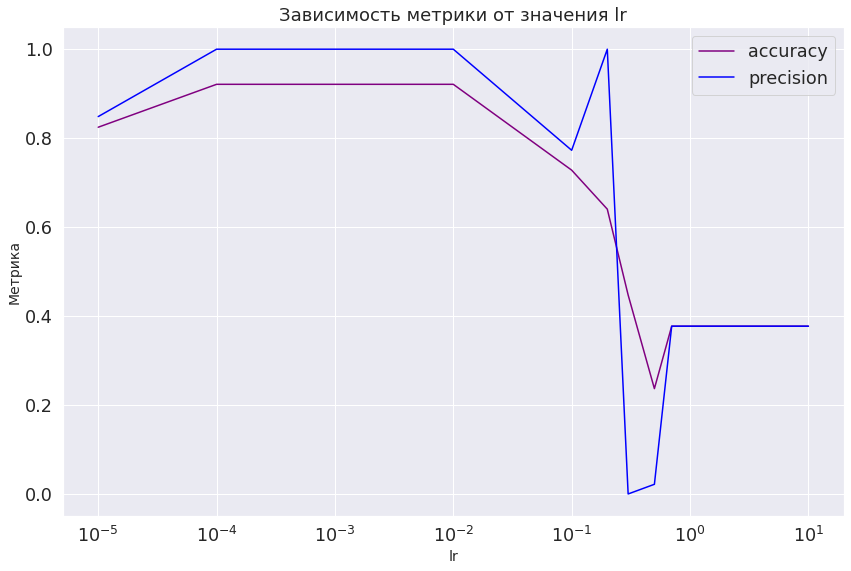

In [25]:
with sns.axes_style('darkgrid'):
  plt.figure(figsize=(14,9))
  plt.title('Зависимость метрики от значения lr', fontsize=18)
  plt.plot(lrs, preds_acc, c='purple', label='accuracy')
  plt.plot(lrs, preds_prec, c='blue', label='precision')
  plt.xlabel('lr', fontsize=14)
  plt.ylabel('Метрика', fontsize=14)
  plt.xscale('log')
  plt.legend()

Как видно, у нас есть значения lr при которых метрика precision дает потрясающий результат - 1, при этом accuracy меньше 1, то есть есть люди, у которых опухоль доброкачетсвенная, но мы на всякий случай отправляем их на второй осмотр - но таких мало

Значение lr, при котором precision=1 а accuracy - наилучшая это 0.001, зафиксируем его и будем исполтзовать дальше

In [26]:
best_lr=1e-3

Рассмотрите несколько моделей, в которых установите не менее 5-ти различных коэффициентов регуляризации, а также модель без регуляризатора. Сравните, влияет ли наличие регуляризации на качество, сделайте выводы. Под качеством подразумевается значение какой-либо выбранной вами метрики качества классификации.

In [31]:
alphas = [0, 1e-4, 1e-3, 1e-1, 0.5, 1, 2, 5, 10]

In [32]:
preds_acc = []
preds_prec = []
for alpha in alphas:
  model = LogisticRegression(max_iter=1000, lr=best_lr, alpha=alpha)
  model.fit(X_train, Y_train)
  preds_acc.append(accuracy_score(Y_test, model.predict(X_test)))
  preds_prec.append(precision_score(Y_test, model.predict(X_test), pos_label=0))

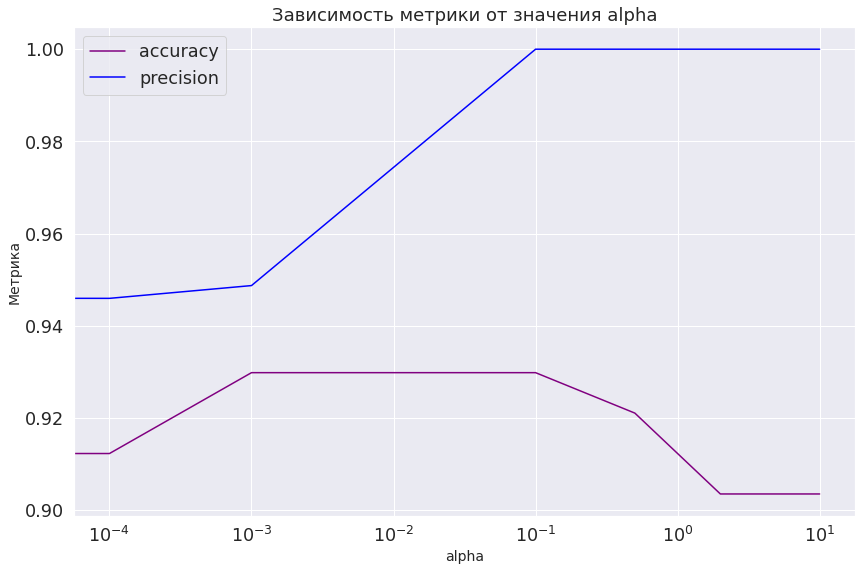

In [33]:
with sns.axes_style('darkgrid'):
  plt.figure(figsize=(14,9))
  plt.title('Зависимость метрики от значения alpha', fontsize=18)
  plt.plot(alphas, preds_acc, c='purple', label='accuracy')
  plt.plot(alphas, preds_prec, c='blue', label='precision')
  plt.xlabel('alpha', fontsize=14)
  plt.ylabel('Метрика', fontsize=14)
  plt.xscale('log')
  plt.legend()

In [34]:
preds_acc

[0.9210526315789473,
 0.9122807017543859,
 0.9298245614035088,
 0.9298245614035088,
 0.9210526315789473,
 0.9122807017543859,
 0.9035087719298246,
 0.9035087719298246,
 0.9035087719298246]

In [35]:
preds_prec

[0.9722222222222222,
 0.9459459459459459,
 0.9487179487179487,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [36]:
best_alpha = 1e-1

Видим, что наличие регуляризации также влияет на значение метрики, precision удалось добить до 1 только при нарастающих alpha, при этом в какой-то момент alpha начинает влиять на accuracy, что наталкивает на мысль о том, что большие коэф регуляризации точно также как и маленькие плохо подходят в данной задаче

При этом, нам удалось по сравнению с прошлым пунктом поднять accuracy, не уронив precision

Выберите объект из тестовой выборки и постройте для него доверительный интервал для предсказания вероятности. Какие условия нужно проверить? 

Построим для рандомного обьекта выборки дов интервал уровня доверия 0.95

In [ ]:
quant_95 = sps.norm().ppf([0.95])


**Вывод:** <...>